In [368]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import optuna.visualization as vis
import time
import scipy.stats as st
from sklearn.model_selection import cross_val_score

In [369]:
df = pd.read_csv("../data/raw/winequality-white.csv", sep=';')

In [370]:
#droping columns that is not much related with target and highly related with other features
df.drop(['citric acid','density','pH'],axis=1,inplace=True)
#reducing skewness with log
df['residual sugar'] = np.log1p(df['residual sugar'])
df['free sulfur dioxide'] = np.log1p(df['free sulfur dioxide'])
df['alcohol'] = np.log1p(df['alcohol'])
df['chlorides'] = np.log1p(df['chlorides'])
df['volatile acidity'] = np.log1p(df['volatile acidity'])
df.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality
0,7.0,0.239017,3.077312,0.044017,3.828641,170.0,0.45,2.282382,6
1,6.3,0.262364,0.955511,0.047837,2.708050,132.0,0.49,2.351375,6
2,8.1,0.246860,2.066863,0.048790,3.433987,97.0,0.44,2.406945,6
3,7.2,0.207014,2.251292,0.056380,3.871201,186.0,0.40,2.388763,6
4,7.2,0.207014,2.251292,0.056380,3.871201,186.0,0.40,2.388763,6


In [371]:
features = df.columns.drop('quality')
# Dictionary to store outlier indices per feature
outliers_dict = {}

# Loop through each feature and identify outliers using IQR
for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    outliers_dict[col] = outliers
    print(f"{col}: {len(outliers)} outliers")

# Example: Print outlier indices for 'residual sugar'
print("\nOutlier indices for 'residual sugar':")
print(outliers_dict['residual sugar'][:10])  # show first 10 indices
# Combine all outlier indices from all features
all_outliers = set()
for idx_list in outliers_dict.values():
    all_outliers.update(idx_list)

#Drop outlier rows from the DataFrame
df_cleaned = df.drop(index=all_outliers).reset_index(drop=True)

print(f"\nOriginal shape: {df.shape}")
print(f"New shape after outlier removal: {df_cleaned.shape}")

fixed acidity: 119 outliers
volatile acidity: 156 outliers
residual sugar: 0 outliers
chlorides: 212 outliers
free sulfur dioxide: 109 outliers
total sulfur dioxide: 19 outliers
sulphates: 124 outliers
alcohol: 0 outliers

Outlier indices for 'residual sugar':
Index([], dtype='int64')

Original shape: (4898, 9)
New shape after outlier removal: (4226, 9)


In [372]:
def quality_label(q):
    if q <= 5:
        return 'low'
    elif q > 5 and q < 8:
        return 'medium'
    else:
        return 'high'

df_cleaned['quality_label'] = df_cleaned['quality'].apply(quality_label)
df_cleaned.head()

,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,sulphates,alcohol,quality,quality_label
0,7.0,0.239017,3.077312,0.044017,3.828641,170.0,0.45,2.282382,6,medium
1,6.3,0.262364,0.955511,0.047837,2.708050,132.0,0.49,2.351375,6,medium
2,8.1,0.246860,2.066863,0.048790,3.433987,97.0,0.44,2.406945,6,medium
3,7.2,0.207014,2.251292,0.056380,3.871201,186.0,0.40,2.388763,6,medium
4,7.2,0.207014,2.251292,0.056380,3.871201,186.0,0.40,2.388763,6,medium


In [373]:
#Train test Split
features = df_cleaned.drop(columns = ['quality','quality_label'])
target = df_cleaned['quality_label']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

In [374]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
knn.score(X_test, y_test)

0.6903073286052009

# KNN Classifier

In [376]:
#Create an instance of the class MinMaxScaler normalizer
normalizer = MinMaxScaler()
#applying .fit()class method only to the train set to find the max and min
normalizer.fit(X_train)
#apply the transformation to training nad testing data
X_train_norm = normalizer.transform(X_train)

X_test_norm = normalizer.transform(X_test)
#converting X_train_norm to pandas Dataframe
X_train_norm = pd.DataFrame(X_train_norm, columns=X_train.columns, index=X_train.index )
#X_train_norm.head()
##converting X_test_norm to pandas Dataframe
X_test_norm = pd.DataFrame(X_test_norm, columns=X_test.columns, index=X_test.index)
#X_test_norm.head()
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_norm, y_train)
knn.score(X_test_norm, y_test)

0.7399527186761229

In [377]:
#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Logistic Regression 

 Accuracy: 0.7257683215130024

 Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00        29
         low       0.63      0.47      0.54       257
      medium       0.75      0.88      0.81       560

    accuracy                           0.73       846
   macro avg       0.46      0.45      0.45       846
weighted avg       0.69      0.73      0.70       846



C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

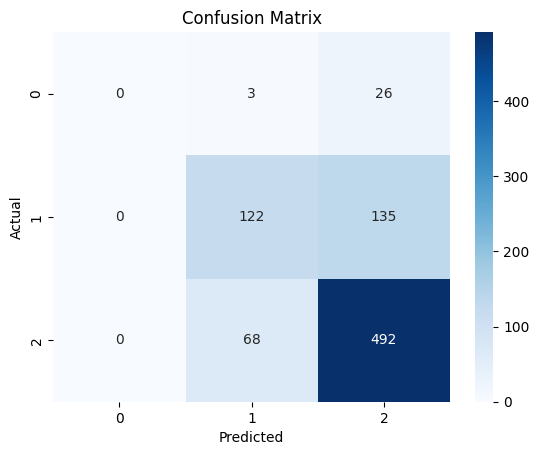

In [379]:
#Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
#predict and evaluate
y_pred = model.predict(X_test_scaled)
y_score1 = model.predict_proba(X_test_scaled)
print(" Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

#Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

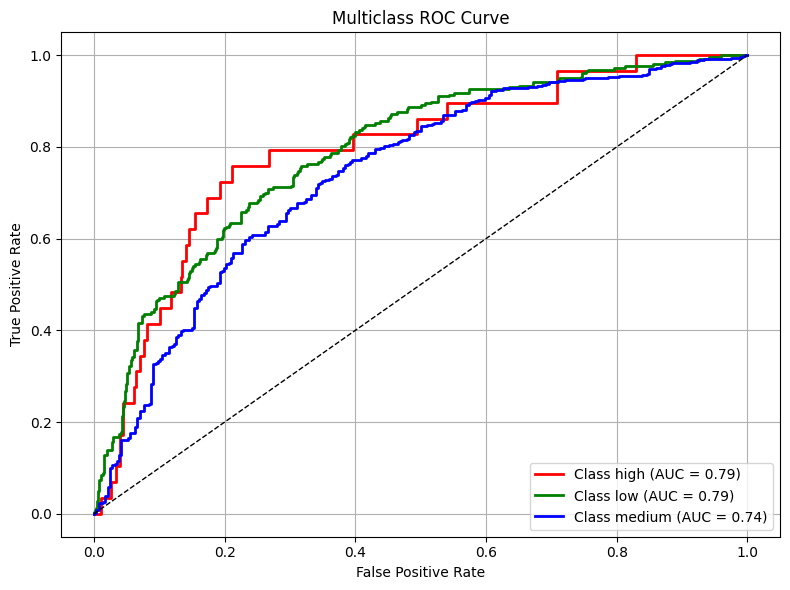

In [380]:
# Binarize the test labels
classes = model.classes_  # or list of unique classes: np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']  # Add more if more classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest Classifier

 Accuracy: 0.8380614657210402

 Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.34      0.51        29
         low       0.83      0.68      0.75       257
      medium       0.84      0.94      0.88       560

    accuracy                           0.84       846
   macro avg       0.89      0.65      0.71       846
weighted avg       0.84      0.84      0.83       846



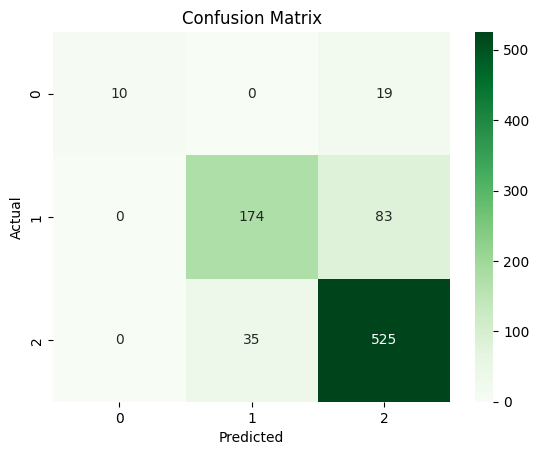

In [382]:
forest = RandomForestClassifier(n_estimators=100,
                             max_depth=20)
forest.fit(X_train_scaled, y_train)
y_pred_test = forest.predict(X_test_scaled)
accuracy_score(y_test, y_pred_test)
confusion_matrix(y_test, y_pred_test)

y_score2= forest.predict_proba(X_test_scaled)
print(" Accuracy:", accuracy_score(y_test, y_pred_test))
print("\n Classification Report:\n", classification_report(y_test, y_pred_test))

#Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

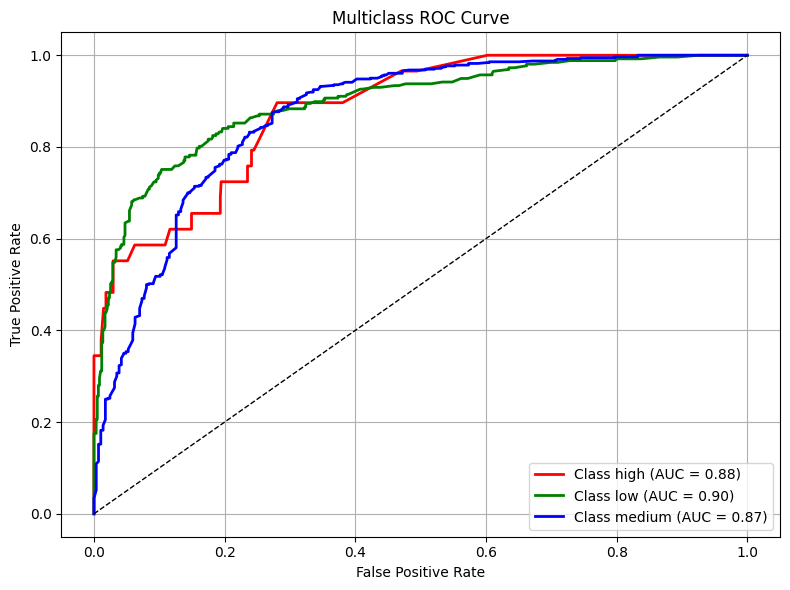

In [383]:
# Binarize the test labels
classes = model.classes_  # or list of unique classes: np.unique(y_train)
y_test_binarized = label_binarize(y_test, classes=classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']  # Add more if more classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Decision Tree Classifier

 Accuracy: 0.7494089834515366

 Classification Report:
               precision    recall  f1-score   support

        high       0.43      0.41      0.42        29
         low       0.65      0.65      0.65       257
      medium       0.81      0.81      0.81       560

    accuracy                           0.75       846
   macro avg       0.63      0.63      0.63       846
weighted avg       0.75      0.75      0.75       846



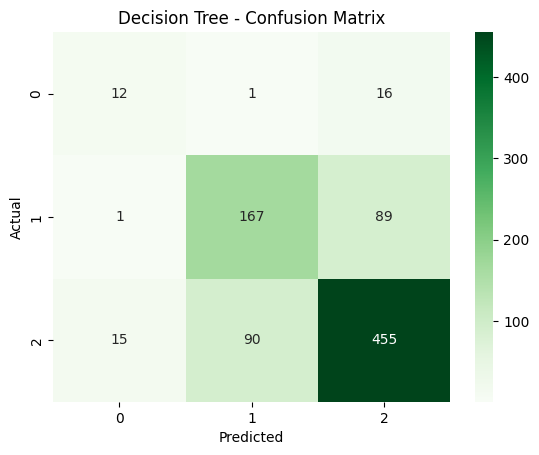

In [385]:

# Create and train the model
tree = DecisionTreeClassifier(max_depth=20, random_state=42)
tree.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_test_tree = tree.predict(X_test_scaled)

# Accuracy and classification report
print(" Accuracy:", accuracy_score(y_test, y_pred_test_tree))
print("\n Classification Report:\n", classification_report(y_test, y_pred_test_tree))

# Confusion matrix
cm_tree = confusion_matrix(y_test, y_pred_test_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

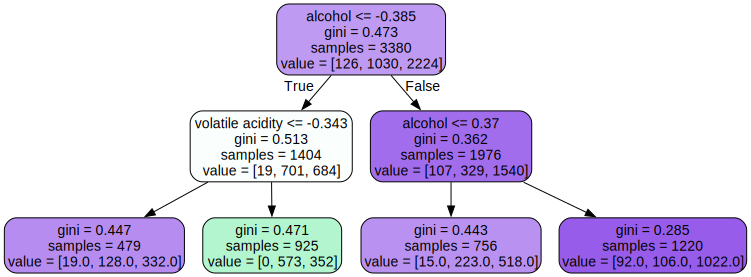

In [386]:


tree = DecisionTreeClassifier(max_depth=2)
tree.fit(X_train_scaled, y_train)


dot_data = export_graphviz(tree, out_file="tree.dot", filled=True, rounded=True, feature_names=X_train_norm.columns)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

# Ada Boost Classifier

 Accuracy: 0.6973995271867612

 Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00        29
         low       0.61      0.33      0.43       257
      medium       0.72      0.90      0.80       560

    accuracy                           0.70       846
   macro avg       0.44      0.41      0.41       846
weighted avg       0.66      0.70      0.66       846



C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

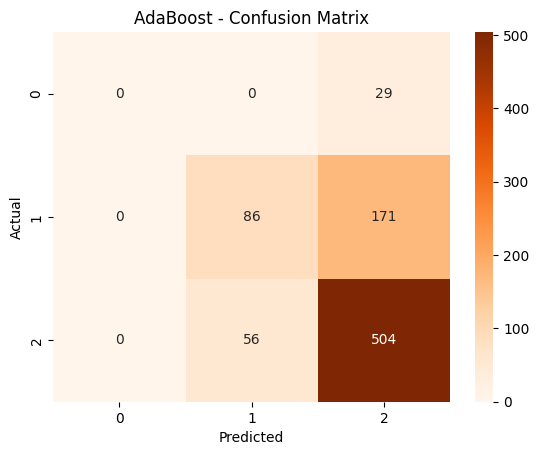

In [388]:

# Create and train the AdaBoost model
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_test_ada = ada.predict(X_test_scaled)

# Accuracy and classification report
print(" Accuracy:", accuracy_score(y_test, y_pred_test_ada))
print("\n Classification Report:\n", classification_report(y_test, y_pred_test_ada))

# Confusion matrix
cm_ada = confusion_matrix(y_test, y_pred_test_ada)
sns.heatmap(cm_ada, annot=True, fmt='d', cmap='Oranges')
plt.title("AdaBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Gradient Boosting Classifier

 Accuracy: 0.7565011820330969

 Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.10      0.19        29
         low       0.69      0.54      0.61       257
      medium       0.78      0.89      0.83       560

    accuracy                           0.76       846
   macro avg       0.82      0.51      0.54       846
weighted avg       0.76      0.76      0.74       846



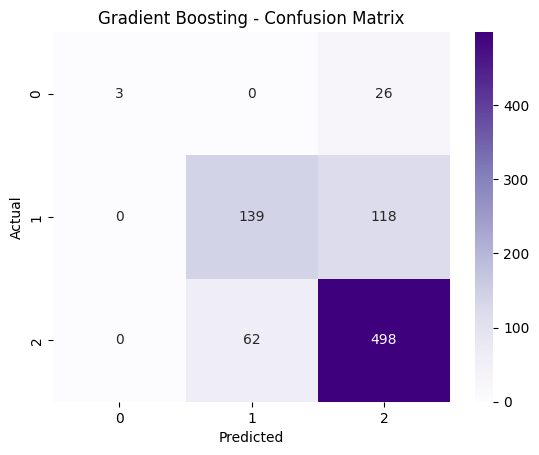

In [390]:
# Create and train the Gradient Boosting model
gb = GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
gb.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_test_gb = gb.predict(X_test_scaled)

# Accuracy and classification report
print(" Accuracy:", accuracy_score(y_test, y_pred_test_gb))
print("\n Classification Report:\n", classification_report(y_test, y_pred_test_gb))

# Confusion matrix
cm_gb = confusion_matrix(y_test, y_pred_test_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Purples')
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Hyperparameter tuning

[I 2025-08-01 12:13:28,473] A new study created in memory with name: no-name-33e34544-42d8-41b3-bdfa-1075f245c64a
[I 2025-08-01 12:13:32,518] Trial 0 finished with value: 0.7440828402366864 and parameters: {'n_estimators': 280, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.7440828402366864.
[I 2025-08-01 12:13:35,168] Trial 1 finished with value: 0.7579881656804733 and parameters: {'n_estimators': 183, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.7579881656804733.
[I 2025-08-01 12:13:37,778] Trial 2 finished with value: 0.7650887573964498 and parameters: {'n_estimators': 194, 'max_depth': 21, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.7650887573964498.
[I 2025-08-01 12:13:38,989] Trial 3 finished with value: 0.7618343195266272 and parameters: {'n_estimators': 53, 'max_depth': 14, 'm



Time taken to find best combination:  133.4671 seconds

Best hyperparameters found: {'n_estimators': 277, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
 Best accuracy found:  0.7994
 Accuracy confidence interval for best run: (np.float64(0.7653), np.float64(0.7994), np.float64(0.8335))

 Final Accuracy on Test Set: 0.8356973995271868

 Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.34      0.51        29
         low       0.83      0.67      0.74       257
      medium       0.84      0.94      0.88       560

    accuracy                           0.84       846
   macro avg       0.89      0.65      0.71       846
weighted avg       0.84      0.84      0.83       846



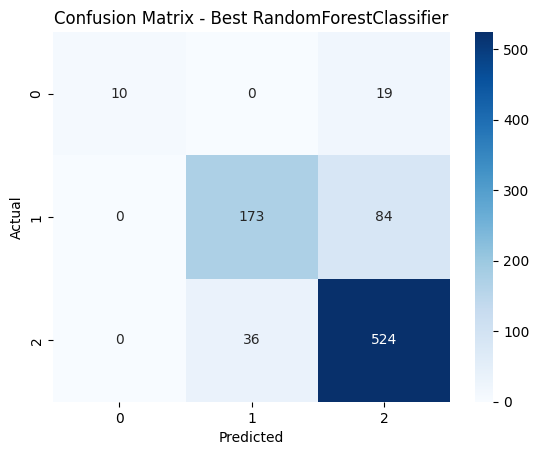

In [392]:
#Bayesian search
# Objective function
def objective(trial, confidence_level, folds):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Define model
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validation scoring (accuracy)
    scores = cross_val_score(clf, X_train_scaled, y_train, cv=folds, scoring='accuracy')
    mean_score = np.mean(scores)
    sem = np.std(scores, ddof=1) / np.sqrt(folds)

    # Confidence interval
    tc = st.t.ppf(1 - (1 - confidence_level) / 2, df=folds - 1)
    lower_bound = mean_score - (tc * sem)
    upper_bound = mean_score + (tc * sem)

    # Save confidence interval in trial
    trial.set_user_attr("CV_score_summary", [round(lower_bound, 4), round(mean_score, 4), round(upper_bound, 4)])

    return mean_score

# Parameters
confidence_level = 0.95
folds = 5  # 5 or 10 depending on speed vs reliability

# Run the optimization
start_time = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, confidence_level, folds), n_trials=45)
end_time = time.time()
bayesian_searchtime=end_time - start_time
# Output results
print("\n")
print(f"Time taken to find best combination: {end_time - start_time: .4f} seconds")
print("\nBest hyperparameters found:", study.best_params)
print(f" Best accuracy found: {study.best_value: .4f}")

# Confidence interval summary
results = sorted([
    (index,
     trial.user_attrs['CV_score_summary'][0],
     trial.user_attrs['CV_score_summary'][1],
     trial.user_attrs['CV_score_summary'][2])
    for index, trial in enumerate(study.trials)
], key=lambda x: x[2], reverse=True)

print(f" Accuracy confidence interval for best run: {results[0][1:]}")


# Train the best model on the full training set
best_clf = RandomForestClassifier(
    **study.best_params,
    random_state=42,
    n_jobs=-1
)
best_clf.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = best_clf.predict(X_test_scaled)

# Evaluation metrics
print("\n Final Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Best RandomForestClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Fitting 10 folds for each of 16 candidates, totalling 160 fits

Time taken: 14.91 seconds

Best hyperparameters found: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Cross-validated best accuracy: 0.8101
95% Confidence Interval for accuracy: (0.7935, 0.8101, 0.8267)

 Test Accuracy: 0.8380614657210402

 Classification Report:
               precision    recall  f1-score   support

        high       1.00      0.34      0.51        29
         low       0.83      0.68      0.75       257
      medium       0.84      0.93      0.88       560

    accuracy                           0.84       846
   macro avg       0.89      0.65      0.72       846
weighted avg       0.84      0.84      0.83       846



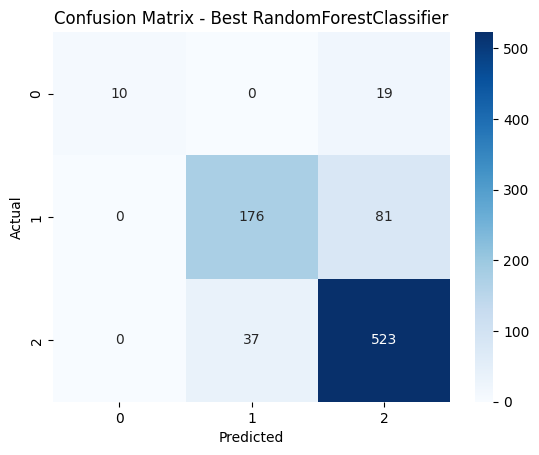

In [393]:
#Grid Search
# Hyperparameter grid
parameter_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 30],
    "min_samples_split": [2, 10],
    "max_features": ["sqrt", "log2"]
}  # Total: 2*2*2*2 = 16 combinations

# Random Forest model
rf = RandomForestClassifier(random_state=123)

# GridSearchCV setup
folds = 10
confidence_level = 0.95
gs = GridSearchCV(rf, param_grid=parameter_grid, cv=folds, verbose=1, scoring='accuracy', n_jobs=-1)

# Fit
start_time = time.time()
gs.fit(X_train_scaled, y_train)
end_time = time.time()
gsearchtime=end_time - start_time
# Timing
print(f"\nTime taken: {end_time - start_time:.2f} seconds")

# Best results
print("\nBest hyperparameters found:", gs.best_params_)
print(f"Cross-validated best accuracy: {gs.best_score_:.4f}")

# Confidence interval
results_gs_df = pd.DataFrame(gs.cv_results_).sort_values(by="mean_test_score", ascending=False)
mean_score = results_gs_df.iloc[0]["mean_test_score"]
std_score = results_gs_df.iloc[0]["std_test_score"]
sem = std_score / np.sqrt(folds)
tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
lower_bound = mean_score - tc * sem
upper_bound = mean_score + tc * sem

print(f"95% Confidence Interval for accuracy: ({lower_bound:.4f}, {mean_score:.4f}, {upper_bound:.4f})")

# Best model
best_model = gs.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test_scaled)
print("\n Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best RandomForestClassifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [394]:
#Random Search
# Hyperparameter grid
parameter_grid = {
    "max_leaf_nodes": [int(x) for x in np.linspace(start=5, stop=30, num=3)],
    "max_depth": [int(x) for x in np.linspace(1, 11, num=3)],
    "n_estimators": [50, 100, 150],
    "min_samples_split": [2, 5, 10],
    "max_features": ["sqrt", "log2"]
}

# Random forest classifier instance
rf = RandomForestClassifier(random_state=123)

# Cross-validation folds and confidence level
folds = 10
confidence_level = 0.95

# Randomized search setup
rs = RandomizedSearchCV(
    rf,
    param_distributions=parameter_grid,
    n_iter=16,
    cv=folds,
    verbose=10,
    random_state=123,
    n_jobs=-1,
    scoring="accuracy"
)

# Fit the model
start_time = time.time()
rs.fit(X_train_scaled, y_train)
end_time = time.time()
rsearchtime=end_time - start_time
print("\n")
print(f"Time taken to find the best combination of hyperparameters: {end_time - start_time:.4f} seconds\n")
print("Best hyperparameters:", rs.best_params_)
print(f"Best cross-validated Accuracy: {rs.best_score_:.4f}")

# Confidence interval calculation
results_rs_df = pd.DataFrame(rs.cv_results_).sort_values(by="mean_test_score", ascending=False)
rs_mean_score = results_rs_df.iloc[0]["mean_test_score"]
rs_std_score = results_rs_df.iloc[0]["std_test_score"]
rs_sem = rs_std_score / np.sqrt(folds)

rs_tc = st.t.ppf(1 - ((1 - confidence_level) / 2), df=folds - 1)
rs_lower_bound = rs_mean_score - rs_tc * rs_sem
rs_upper_bound = rs_mean_score + rs_tc * rs_sem

print(f"Accuracy confidence interval for the best combination: ({rs_lower_bound:.4f}, {rs_mean_score:.4f}, {rs_upper_bound:.4f})")

# Store best model
best_model_rs= rs.best_estimator_

# Evaluate on test data
y_pred_test = best_model_rs.predict(X_test_scaled)

print("\n Test Set Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


Time taken to find the best combination of hyperparameters: 4.6803 seconds

Best hyperparameters: {'n_estimators': 100, 'min_samples_split': 5, 'max_leaf_nodes': 30, 'max_features': 'sqrt', 'max_depth': 11}
Best cross-validated Accuracy: 0.7470
Accuracy confidence interval for the best combination: (0.7331, 0.7470, 0.7610)

 Test Set Evaluation:
Test Accuracy: 0.7388

Classification Report:
               precision    recall  f1-score   support

        high       0.00      0.00      0.00        29
         low       0.69      0.46      0.55       257
      medium       0.75      0.91      0.82       560

    accuracy                           0.74       846
   macro avg       0.48      0.45      0.46       846
weighted avg       0.71      0.74      0.71       846


Confusion Matrix:
 [[  0   0  29]
 [  0 118 139]
 [  0  53 507]]


C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\sheri\desktop\ironhack\unit7\white_wine_project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

In [395]:
comparison_df = pd.DataFrame({
    "Method": ["GridSearch", "RandomSearch", "BayesianOptuna"],
    "Best Score (CV)": [gs.best_score_, rs.best_score_, study.best_value],
    "Confidence Interval (CV)": [
        (lower_bound, mean_score, upper_bound),
        (rs_lower_bound, rs_mean_score, rs_upper_bound),
        results[0][1:]  # From your Optuna study
    ],
    "Test Score (R2 or Accuracy)": [
        best_model.score(X_test_scaled, y_test),
        best_model_rs.score(X_test_scaled, y_test),
        results[0][1:]
    ],
    "Training Time (sec)": [
        gsearchtime,
        rsearchtime,
        bayesian_searchtime
    ]
})
print(comparison_df)

           Method  Best Score (CV)  \
0      GridSearch         0.810059   
1    RandomSearch         0.747041   
2  BayesianOptuna         0.799408   

                            Confidence Interval (CV)  \
0  (0.7934535407361516, 0.8100591715976332, 0.826...   
1  (0.7331227055199798, 0.7470414201183432, 0.760...   
2                           (0.7653, 0.7994, 0.8335)   

  Test Score (R2 or Accuracy)  Training Time (sec)  
0                    0.838061            14.910879  
1                    0.738771             4.680313  
2    (0.7653, 0.7994, 0.8335)           133.467108  


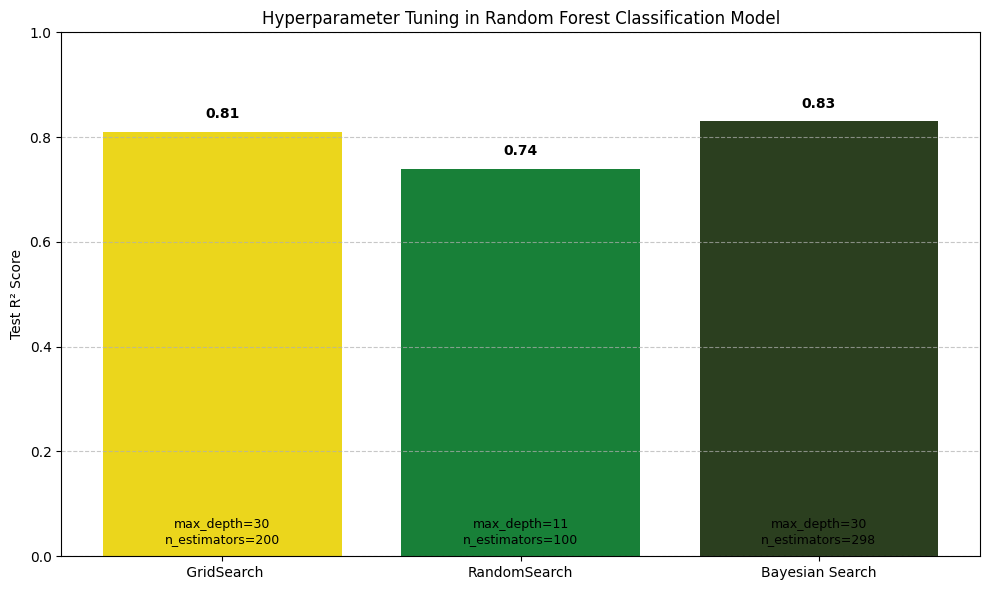

In [423]:
import matplotlib.pyplot as plt

# Model info
models = [" GridSearch", "RandomSearch", "Bayesian Search"]
test_scores = [0.81, 0.74, 0.83]

# Add corresponding best hyperparameters as strings
param_labels = [
    "max_depth=30\nn_estimators=200",
    "max_depth=11\nn_estimators=100",
    "max_depth=30\nn_estimators=298"
]

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, test_scores, color=["#EBD61C", "#188038", "#2B3F1F"])
plt.ylabel("Test R² Score")
plt.title("Hyperparameter Tuning in Random Forest Classification Model")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle='--', alpha=0.7)

# Add parameter annotations above or inside bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f"{test_scores[i]:.2f}", 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
    
    plt.text(bar.get_x() + bar.get_width() / 2, 0.02, param_labels[i], 
             ha='center', va='bottom', fontsize=9, color='black', rotation=0)

plt.tight_layout()
plt.savefig("model_comparison_with_params.png")
plt.show()
